# Logistic Regression

In [47]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [32]:
df = pd.read_csv('treated_data.csv')

### Evaluating Function

In [33]:
def evaluate(y_true, y_prob, titulo="Model"):
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n{titulo}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], '--')
    plt.title(f"ROC Curve - {titulo}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [34]:
df = df.drop(['types', 'Unnamed: 0'], axis = 1)
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Hold-Out Validation


Logistic Regression - Test
Accuracy:  0.9992
Precision:  0.8861
Recall:    0.4176
AUC-ROC:   0.9793


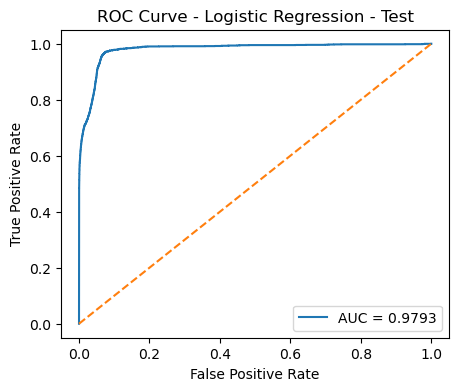

In [35]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:,1]

evaluate(y_test, y_prob, "Logistic Regression - Test")

## K-Fold


K-Fold 1
Accuracy:  0.9992
Precision:  0.9047
Recall:    0.4254
AUC-ROC:   0.9783


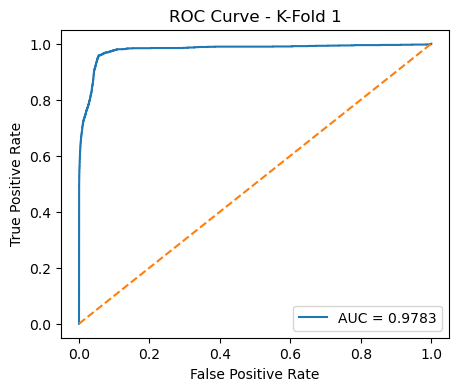


K-Fold 2
Accuracy:  0.9992
Precision:  0.8919
Recall:    0.4451
AUC-ROC:   0.9789


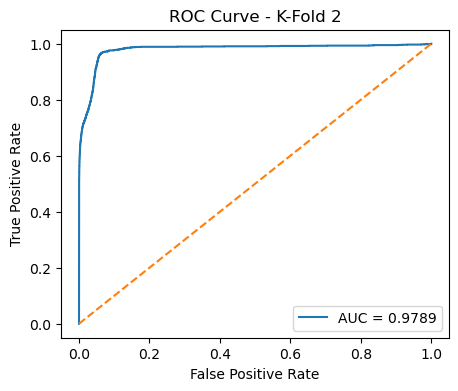


K-Fold 3
Accuracy:  0.9992
Precision:  0.8708
Recall:    0.4317
AUC-ROC:   0.9771


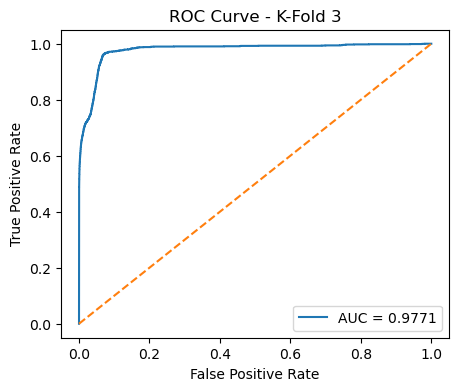


K-Fold 4
Accuracy:  0.9992
Precision:  0.8828
Recall:    0.4380
AUC-ROC:   0.9777


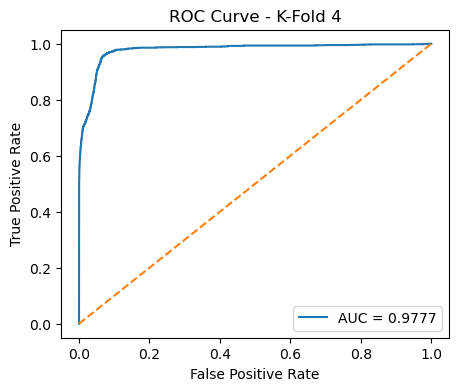


K-Fold 5
Accuracy:  0.9992
Precision:  0.8501
Recall:    0.4374
AUC-ROC:   0.9813


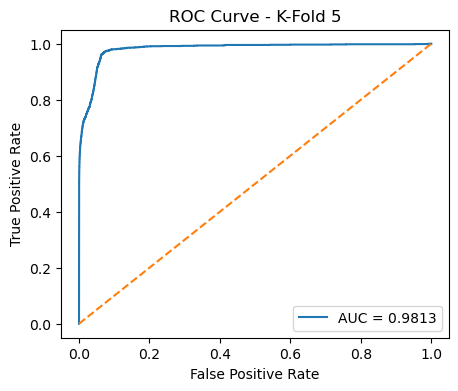

In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_idx, test_idx in kf.split(X):
    X_train_k, X_test_k = X.iloc[train_idx], X.iloc[test_idx]
    y_train_k, y_test_k = y.iloc[train_idx], y.iloc[test_idx]

    model_k = LogisticRegression(max_iter=2000)
    model_k.fit(X_train_k, y_train_k)

    y_prob_k = model_k.predict_proba(X_test_k)[:,1]

    evaluate(y_test_k, y_prob_k, f"K-Fold {fold}")
    fold += 1

## Class Weights

Weights: {0: 0.5006450389368385, 1: 388.07350250091497}

Logistic Regression - Class Weight
Accuracy:  0.9607
Precision:  0.0275
Recall:    0.8597
AUC-ROC:   0.9809


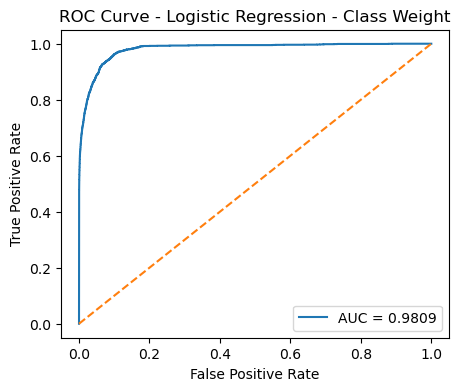

In [37]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

class_weights = {0: class_weights[0], 1: class_weights[1]}
print("Weights:", class_weights)

model_w = LogisticRegression(class_weight=class_weights, max_iter=2000)
model_w.fit(X_train, y_train)

y_prob_w = model_w.predict_proba(X_test)[:,1]

evaluate(y_test, y_prob_w, "Logistic Regression - Class Weight")

## Undersampling


Undersampling
Accuracy:  0.9860
Precision:  0.0741
Recall:    0.8577
AUC-ROC:   0.9917


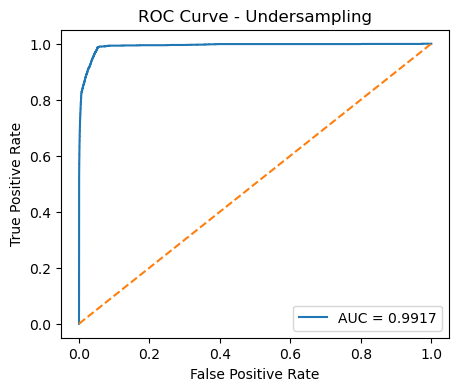

In [42]:
df_train = pd.concat([X_train, y_train], axis=1)
df0 = df_train[df_train['isFraud'] == 0]
df1 = df_train[df_train['isFraud'] == 1]

df0_under = resample(
    df0,
    replace=False,
    n_samples=len(df1) * 5,
    random_state=42
)

df_train_bal = pd.concat([df0_under, df1])

X_train_b = df_train_bal.drop(['isFraud'], axis=1)
y_train_b = df_train_bal['isFraud']

model_b = LogisticRegression(max_iter=2000)
model_b.fit(X_train_b, y_train_b)

y_prob_real = model_b.predict_proba(X_test)[:,1]

evaluate(y_test, y_prob_real, "Undersampling")

## Grid Search

In [48]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}

logreg = LogisticRegression(max_iter=2000)

grid = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_b, y_train_b)

print("Best parameters:", grid.best_params_)
print("Best recall (CV):", grid.best_score_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best recall (CV): 0.9818757331653569



Logistic Regression - Tuned for Recall
Accuracy:  0.6551
Precision:  0.0036
Recall:    0.9797
AUC-ROC:   0.9754


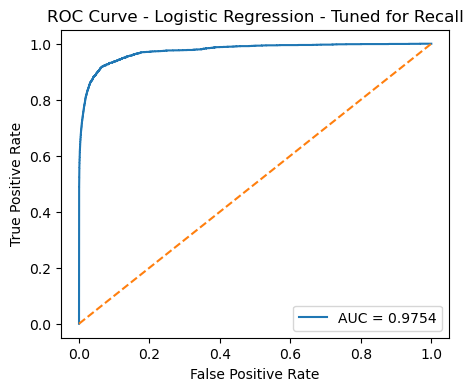

In [ ]:
best_model = grid.best_estimator_
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]
evaluate(y_test, y_prob_tuned, "Logistic Regression - Tuned for Recall")